In [5]:
import numpy as np
import sys
import os
import glob
import getpass
import argparse
import pickle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import fnmatch 
from tqdm import tqdm 
import fnmatch 
import torch 

In [6]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

av_window=10

In [15]:
from utils import save_dir, analyze_dir, result_dir
model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
analyze_identifier= 'mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5'
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06-Dec2020'

In [21]:
# load accuracy data first 
training_files=[]
for file in os.listdir(os.path.join(save_dir,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*.pth'):
            training_files.append(os.path.join(save_dir,model_identifier,train_identifier,file))


hier_accu=[]
for idx, files in tqdm(enumerate(training_files)):
    test=torch.load(files)
    hier_accu.append([test['epoch'],test['batchidx'], test['hier_test_acc']])
dummy=[]
epochs=[]
batches=[]
for item in hier_accu:
    epochs.append(item[0])
    batches.append(item[1])
    dummy.append(item[0]*10000+item[1])
fixed_idx=np.argsort(dummy)

FileNotFoundError: [Errno 2] No such file or directory: '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/extracted/NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed/epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'

In [18]:
hier_accu=[hier_accu[x] for x in fixed_idx]
accuracies=np.stack([x[2] for x in hier_accu])
batches=np.stack([x[1] for x in hier_accu])
epochs=np.stack([x[0] for x in hier_accu])
epoch_factor=1e3*np.ceil(np.max(batches)/1e3)
epoch_batch=epoch_factor*epochs+batches

In [22]:
# load mftma files 
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'
data_=pickle.load(open(os.path.join(analyze_dir,analyze_identifier,model_identifier,train_identifier, f'{model_identifier}_mftma_pooled.pkl'), 'rb'))

mftma_res=data_['mftma_results']
#if not os.path.exists(os.path.join(result_dir,analyze_identifier,model_identifier)):
#        os.makedirs(os.path.join(result_dir,analyze_identifier,model_identifier))
temp=[np.asarray([x['seq'] for x in mftma_res[y]]) for y in mftma_res.keys()]
y=temp[0]
for k in temp:
    y=np.intersect1d(y,k)

In [23]:
mftma_epochs=[np.asarray([x['epoch'] for x in mftma_res[y]]) for y in mftma_res.keys()]
mftma_batch=[np.asarray([x['batch'] for x in mftma_res[y]]) for y in mftma_res.keys()]


1060

In [24]:
l_num=1
layer_data=mftma_res['layer_1_Linear']
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_correspondance=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

In [25]:
layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))

corrected_data=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_correspondance):
    corrected_data[int(x)]=layer_cap[idx,:]

In [26]:
x_bar= np.arange(len(batches))/len(batches)
epoch_bar=np.argwhere(np.diff(epochs))/(len(batches))
epoch_bar

array([[0.0990566],
       [0.1990566],
       [0.2990566],
       [0.3990566],
       [0.4990566],
       [0.5990566],
       [0.6990566],
       [0.7990566],
       [0.8990566]])

range(0, 5)

[[None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None]]

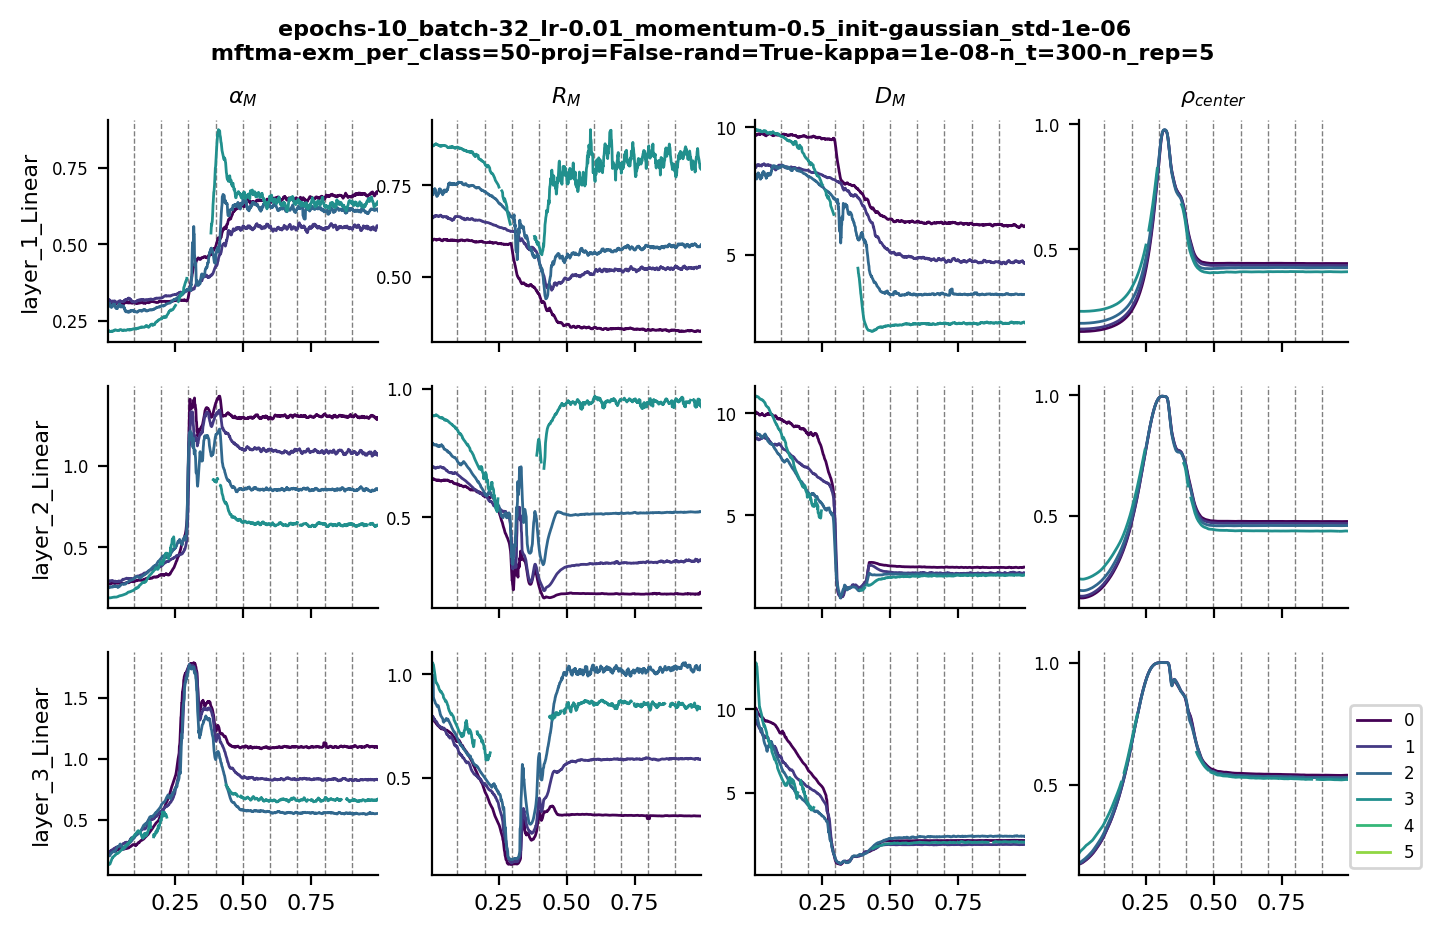

In [27]:
num_colors=accuracies.shape[1]+1
h0=cm.get_cmap('viridis_r',num_colors)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))

num_hier=np.unique([len(x['mftma']) for x in mftma_res['layer_0_Input']])
num_layers=len(mftma_res.keys())
layer_keys=list(mftma_res.keys())
mftma_keys=['capacities','radii','dimensions','correlations']
fig, axes = plt.subplots(3, 4, figsize=(8, 5),dpi=200,frameon=False)

axes=axes.flatten()
[plt.setp(ax.get_xticklabels(), fontsize=6) for ax in axes]
[plt.setp(ax.get_yticklabels(), fontsize=6) for ax in axes]
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# plot layer 1 results
l_num=1
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$\alpha_M$', fontsize=8)
ax.set_ylabel(layer_keys[l_num], fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$R_M$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$D_M$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+3]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$\rho_{center}$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
   
    
# plot layer 2 results
l_num=2
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_ylabel(layer_keys[l_num], fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+3]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
   

# plot layer 2 results
l_num=3
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_ylabel(layer_keys[l_num], fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)


ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)


ax=axes[(l_num-1)*len(mftma_keys)+3]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.legend(bbox_to_anchor=(1, .5, 0.3, 0.3),fontsize=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

plt.suptitle(f"{train_identifier} \n {analyze_identifier}",fontsize=8, fontweight='bold')
#plt.tight_layout()
# plt.show()
# fig.savefig(os.path.join(result_dir,analyze_identifier,model_identifier+'_manifold_vals_during_training.png'),transparent=True)
[plt.setp(ax.get_xticklabels(), fontsize=8) for ax in axes]

# zooming in 

[[None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None]]

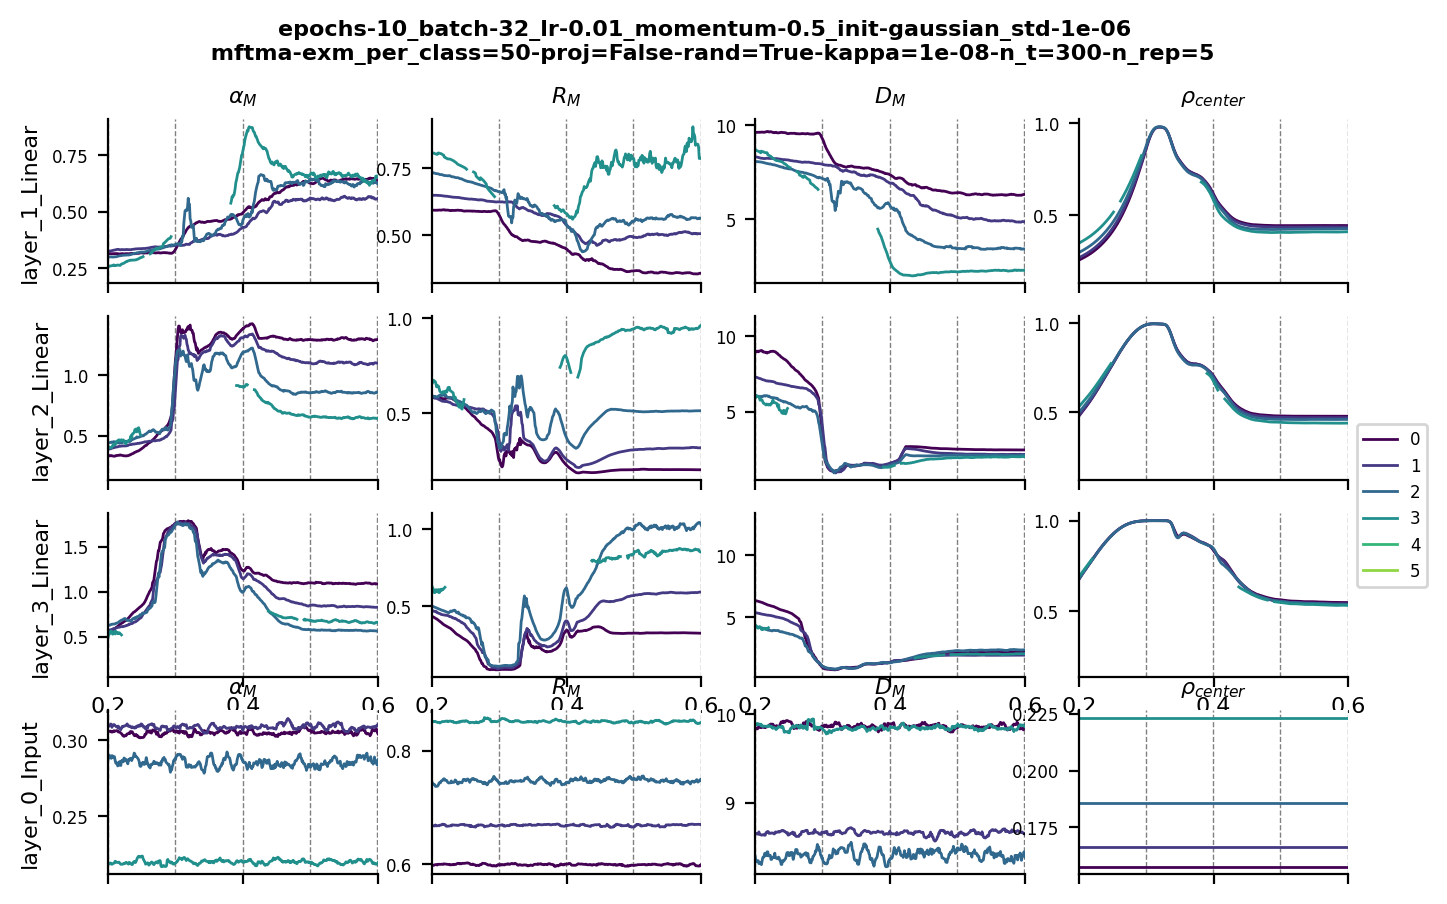

In [28]:
xmin=.2
xmax=.6

num_colors=accuracies.shape[1]+1
h0=cm.get_cmap('viridis_r',num_colors)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))

num_hier=np.unique([len(x['mftma']) for x in mftma_res['layer_0_Input']])
num_layers=len(mftma_res.keys())
layer_keys=list(mftma_res.keys())
mftma_keys=['capacities','radii','dimensions','correlations']
fig, axes = plt.subplots(4, 4, figsize=(8, 5),dpi=200,frameon=False)

axes=axes.flatten()
[plt.setp(ax.get_xticklabels(), fontsize=6) for ax in axes]
[plt.setp(ax.get_yticklabels(), fontsize=6) for ax in axes]
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])

l_num=0
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$\alpha_M$', fontsize=8)
ax.set_ylabel(layer_keys[l_num], fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$R_M$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))

ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$D_M$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))

ax=axes[(l_num-1)*len(mftma_keys)+3]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$\rho_{center}$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))
   

# plot layer 1 results
l_num=1
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$\alpha_M$', fontsize=8)
ax.set_ylabel(layer_keys[l_num], fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$R_M$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))

ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$D_M$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))

ax=axes[(l_num-1)*len(mftma_keys)+3]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$\rho_{center}$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))
   
    
# plot layer 2 results
l_num=2
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_ylabel(layer_keys[l_num], fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))

ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))

ax=axes[(l_num-1)*len(mftma_keys)+3]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))
   

# plot layer 2 results
l_num=3
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_ylabel(layer_keys[l_num], fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))

ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))


ax=axes[(l_num-1)*len(mftma_keys)+3]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(x_bar,av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.legend(bbox_to_anchor=(1, .5, 0.3, 0.3),fontsize=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim((xmin,xmax))

plt.suptitle(f"{train_identifier} \n {analyze_identifier}",fontsize=8, fontweight='bold')
#plt.tight_layout()
# plt.show()
# fig.savefig(os.path.join(result_dir,analyze_identifier,model_identifier+'_manifold_vals_during_training.png'),transparent=True)
[plt.setp(ax.get_xticklabels(), fontsize=8) for ax in axes]

# plot accuracy against capacity 

In [29]:
import matplotlib.markers as markers 

In [30]:
markers.CARETDOWN

7

In [31]:
accuracies.shape[0]

1060

In [32]:
h0=cm.get_cmap('magma_r',accuracies.shape[0])
dot_cols=np.flipud(h0(np.arange(accuracies.shape[0])/accuracies.shape[0]))
dot_ave=[]
for k in range(dot_cols.shape[1]):
    dot_ave.append(moving_average(dot_cols[:,k],av_window))
dot_ave=np.stack(dot_ave).transpose()

In [33]:
marker_seq=["o",'v','s','^','>','D']

In [43]:
array_corres[-1]

array([[1059]])

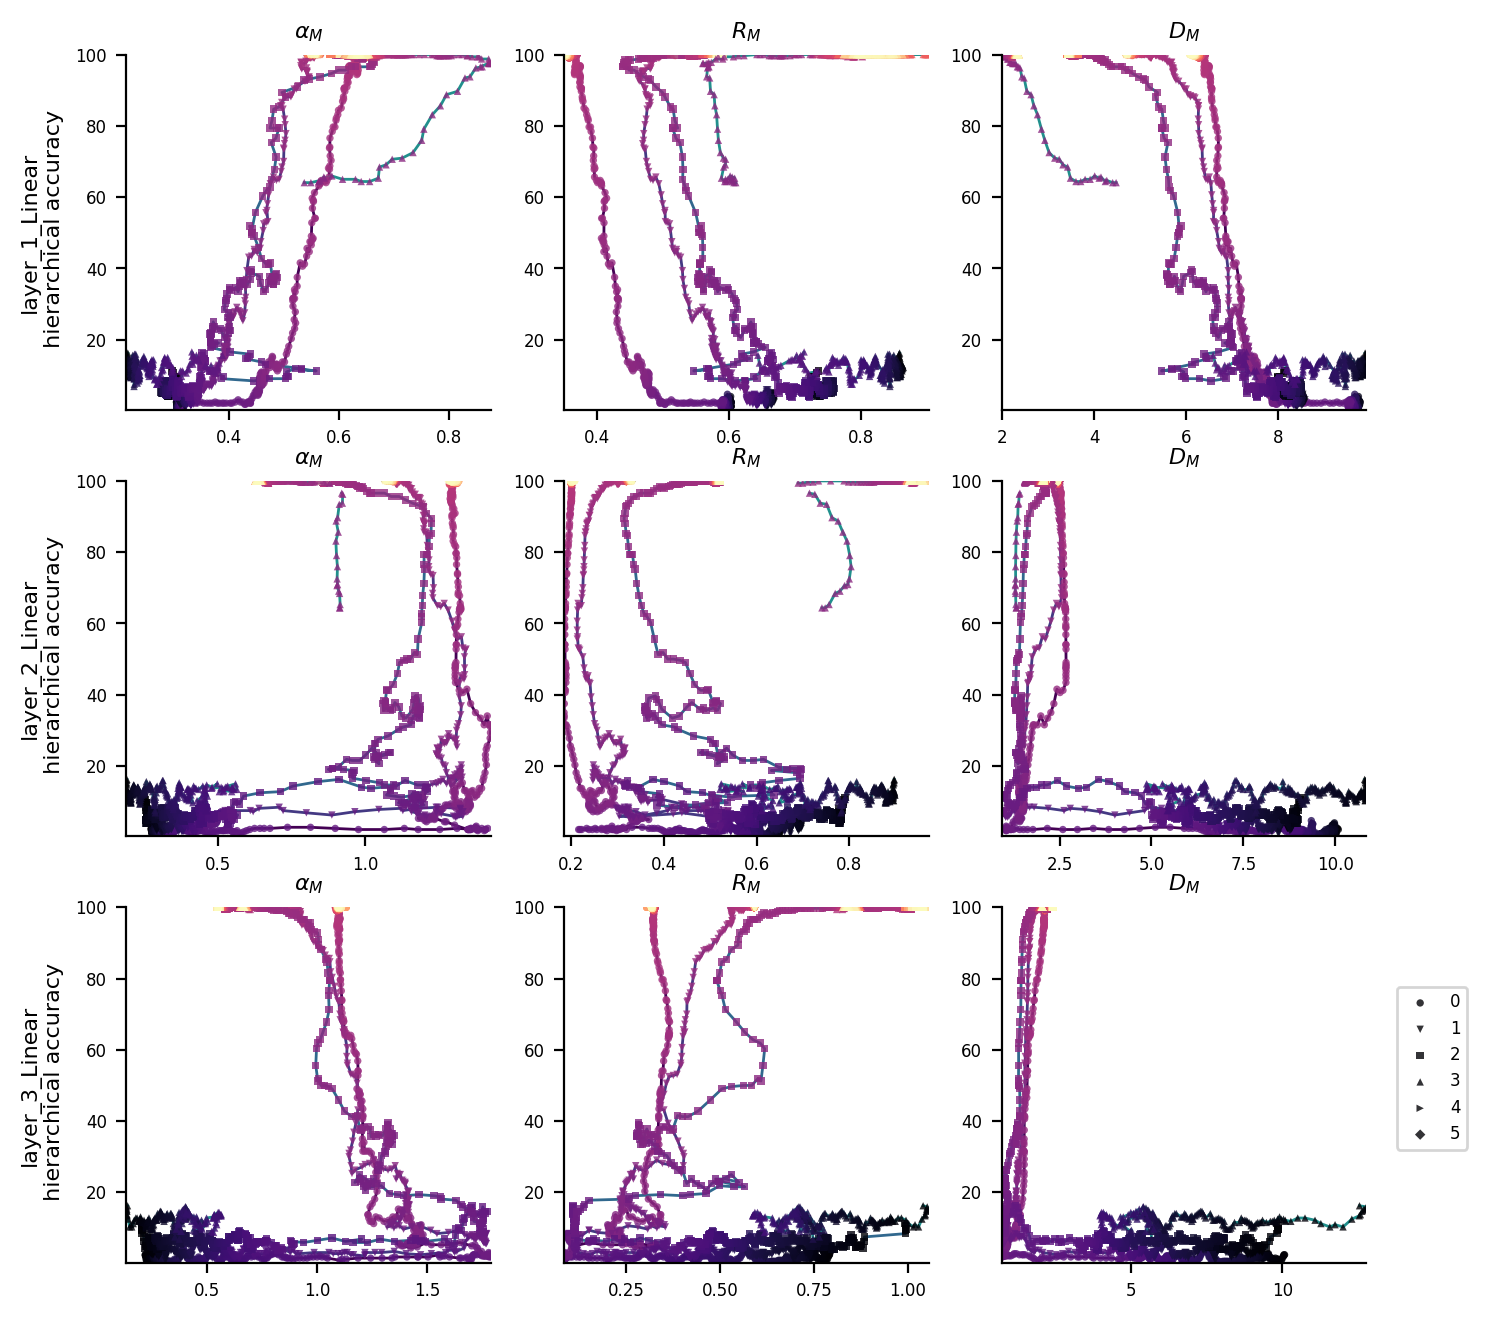

In [37]:

h0=cm.get_cmap('magma_r',accuracies.shape[0])
dot_cols=np.flipud(h0(np.arange(accuracies.shape[0])/accuracies.shape[0]))

num_colors=accuracies.shape[1]+1
h0=cm.get_cmap('viridis_r',num_colors)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))

num_hier=np.unique([len(x['mftma']) for x in mftma_res['layer_0_Input']])
num_layers=len(mftma_res.keys())
layer_keys=list(mftma_res.keys())
mftma_keys=['capacities','radii','dimensions']
fig, axes = plt.subplots(3, 3, figsize=(8, 8),dpi=200,frameon=False)

axes=axes.flatten()
[plt.setp(ax.get_xticklabels(), fontsize=6) for ax in axes]
[plt.setp(ax.get_yticklabels(), fontsize=6) for ax in axes]
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# plot layer 1 results
l_num=1
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
#layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
#corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    #corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    #if not np.isnan(np.sum(np.stack(corrected_cap)[:,h])):
        ax.plot(moving_average(np.stack(corrected_cap)[:,h],av_window),moving_average(accuracies[:,h],av_window),zorder=0,linewidth=1,color=line_cols[h,:])
        ax.scatter(moving_average(np.stack(corrected_cap)[:,h],av_window),moving_average(accuracies[:,h],av_window),s=7,c=dot_ave,marker=marker_seq[h],alpha=.8,edgecolors='none')
        
ax.set_title(r'$\alpha_M$', fontsize=8)
ax.set_ylabel(f"{layer_keys[l_num]}\n hierarchical accuracy", fontsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    #if not np.isnan(np.sum(np.stack(corrected_rad)[:,h])):
        ax.plot(moving_average(np.stack(corrected_rad)[:,h],av_window),moving_average(accuracies[:,h],av_window),zorder=0,linewidth=1,color=line_cols[h,:])
        ax.scatter(moving_average(np.stack(corrected_rad)[:,h],av_window),moving_average(accuracies[:,h],av_window),s=7,c=dot_ave,marker=marker_seq[h],alpha=.8,edgecolors='none')


ax.set_title(r'$R_M$', fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
     # if not np.isnan(np.sum(np.stack(corrected_dim)[:,h])):
        ax.plot(moving_average(np.stack(corrected_dim)[:,h],av_window),moving_average(accuracies[:,h],av_window),zorder=0,linewidth=1,color=line_cols[h,:])
        ax.scatter(moving_average(np.stack(corrected_dim)[:,h],av_window),moving_average(accuracies[:,h],av_window),s=7,c=dot_ave,marker=marker_seq[h],alpha=.8,edgecolors='none')



ax.set_title(r'$D_M$', fontsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)


# 
# plot layer 1 results
l_num=2
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
#layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
#corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    #corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    #if not np.isnan(np.sum(np.stack(corrected_cap)[:,h])):
        ax.plot(moving_average(np.stack(corrected_cap)[:,h],av_window),moving_average(accuracies[:,h],av_window),zorder=0,linewidth=1,color=line_cols[h,:])
        ax.scatter(moving_average(np.stack(corrected_cap)[:,h],av_window),moving_average(accuracies[:,h],av_window),s=7,c=dot_ave,marker=marker_seq[h],alpha=.8,edgecolors='none')
        
ax.set_title(r'$\alpha_M$', fontsize=8)
ax.set_ylabel(f"{layer_keys[l_num]}\n hierarchical accuracy", fontsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    #if not np.isnan(np.sum(np.stack(corrected_rad)[:,h])):
        ax.plot(moving_average(np.stack(corrected_rad)[:,h],av_window),moving_average(accuracies[:,h],av_window),zorder=0,linewidth=1,color=line_cols[h,:])
        ax.scatter(moving_average(np.stack(corrected_rad)[:,h],av_window),moving_average(accuracies[:,h],av_window),s=7,c=dot_ave,marker=marker_seq[h],alpha=.8,edgecolors='none')


ax.set_title(r'$R_M$', fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
     # if not np.isnan(np.sum(np.stack(corrected_dim)[:,h])):
        ax.plot(moving_average(np.stack(corrected_dim)[:,h],av_window),moving_average(accuracies[:,h],av_window),zorder=0,linewidth=1,color=line_cols[h,:])
        ax.scatter(moving_average(np.stack(corrected_dim)[:,h],av_window),moving_average(accuracies[:,h],av_window),s=7,c=dot_ave,marker=marker_seq[h],alpha=.8,edgecolors='none')



ax.set_title(r'$D_M$', fontsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)


# plot layer 1 results
l_num=3
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
#layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
#corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    #corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    #if not np.isnan(np.sum(np.stack(corrected_cap)[:,h])):
        ax.plot(moving_average(np.stack(corrected_cap)[:,h],av_window),moving_average(accuracies[:,h],av_window),zorder=0,linewidth=1,color=line_cols[h,:])
        ax.scatter(moving_average(np.stack(corrected_cap)[:,h],av_window),moving_average(accuracies[:,h],av_window),s=7,c=dot_ave,marker=marker_seq[h],alpha=.8,edgecolors='none')
        
ax.set_title(r'$\alpha_M$', fontsize=8)
ax.set_ylabel(f"{layer_keys[l_num]}\n hierarchical accuracy", fontsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    #if not np.isnan(np.sum(np.stack(corrected_rad)[:,h])):
        ax.plot(moving_average(np.stack(corrected_rad)[:,h],av_window),moving_average(accuracies[:,h],av_window),zorder=0,linewidth=1,color=line_cols[h,:])
        ax.scatter(moving_average(np.stack(corrected_rad)[:,h],av_window),moving_average(accuracies[:,h],av_window),s=7,c=dot_ave,marker=marker_seq[h],alpha=.8,edgecolors='none')


ax.set_title(r'$R_M$', fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
     # if not np.isnan(np.sum(np.stack(corrected_dim)[:,h])):
        ax.plot(moving_average(np.stack(corrected_dim)[:,h],av_window),moving_average(accuracies[:,h],av_window),zorder=0,linewidth=1,color=line_cols[h,:])
        ax.scatter(moving_average(np.stack(corrected_dim)[:,h],av_window),moving_average(accuracies[:,h],av_window),s=7,c=dot_ave,marker=marker_seq[h],alpha=.8,edgecolors='none',label=str(h))



ax.set_title(r'$D_M$', fontsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.legend(bbox_to_anchor=(1, .5, 0.3, 0.3),fontsize=6)